In [58]:
import csv
import turicreate as tc
from turicreate import SFrame, SArray
from math import sin, cos, sqrt, atan2, radians
from scipy.spatial import distance
import difflib

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import FeatureAgglomeration

In [13]:
gps_cat = ['ts', 'sensorid', 'gpslat', 'gpslon']
gps_sen = ['ts', 'sensorid', 'mac']
csv_gps = 'mov_gps.csv'
csv_sen = 'mov_sensing.csv'

In [230]:
def load_data(input_csv, gps):
    with open(input_csv) as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        count = 0
        line = []
        for row in reader:
            row[1] = row[1].split(';')
            if '' in row[1]:
                row[1].remove('')
            row[1].insert(0, row[0])
            del(row[1][2:4])
            if(gps):
                del(row[1][4:])
            else:
                del(row[1][3:])
            line.append(row[1])
        return line
    
# Create SFrame for gps data and sensing data
def create_frame(list_data, name):
    list_date = []
    list_time = []
    if 'gps' in name:
        list_lat = []
        list_lon = []
        for data in list_data:
        # Iterate thourgh the whole list of gps_data and extract values accordingly
            list_date.append(data[0])
            list_time.append(data[1])
            list_lat.append(data[2])
            list_lon.append(data[3])
        return SFrame({'date':list_date, 'time':list_time, 'lat': list_lat, 'lon':list_lon})
    else:
        list_mac = []
        for data in list_data:
        # Iterate thourgh the whole list of gps_data and extract values accordingly
            list_date.append(data[0])
            list_time.append(data[1])
            list_mac.append(data[2])
        return SFrame({'date':list_date, 'time':list_time, 'mac':list_mac})
    
def check_error(count, mac, date):
    amount = 0
    for item in sen_frame:
        if item['mac'] == mac and item['date'] == date:
            amount+=1
    if amount != count:
        print(mac, date)

def check_last_index(a, element):
    index = -1
    position = 0
    for item in a:
        if item == element:
            index = position
        position+=1
    return index

def time_convert(time):
    s_list = time.split(':')
    if len(s_list) == 3:
        return 3600*float(s_list[0]) + 60*float(s_list[1]) + float(s_list[2])
    else:
        return 3600*float(s_list[0]) + 60*float(s_list[1])

def time_difference(time1, time2):
    return time_convert(time2) - time_convert(time1)

def find(tag1, con1, tag2, con2):
    for item in data:
        if item[tag1] == con1 and item[tag2] == con2:
            print(item)

def find_distance(s_lat, s_lon, e_lat, e_lon):
    R = 6373.0

    lat1 = radians(s_lat)
    lon1 = radians(s_lon)
    lat2 = radians(e_lat)
    lon2 = radians(e_lon)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c * 1000

def compute_data_difference(set1, set2):
    cumulative = 0
    summation = 0
    for i, j in zip(set1, set2):
        cumulative += (i-j)**2
        if j != 0:
            summation += i/j
        else:
            summation += i/1
    scalor = summation / len(set1)
    return sqrt(cumulative), scalor

def normalize(v):
    largest = v.max()
    if largest == 0: 
        return v
    return v / largest

# Compute the Silhouette Coefficient
def compute_Sil_socre(data, labels):
    score = metrics.silhouette_score(pca, labels, metric='euclidean')
    print(score)
    
def format_transform(date):
    temp = date.split('/')
    if len(temp[1]) == 2:
        return '20' + temp[2] + '-0' + temp[0] + '-' + temp[1]
    else:
        return '20' + temp[2] + '-0' + temp[0] + '-0' + temp[1]

def computePassen(labels):  
    count = 0
    for i in range(len(labels)):
        if labels[i] == 1:
            count+=1
    print(count)

def evaluate(a, b):
    score_mape = mape(a, b)
    score_mse = mse(a, b)
    print("Mean Abosulute Percentage Error: ", score_mape)
    print("Mean Square Error: ", score_mse)

def mape(a, b): 
    mask = a != 0
    a = a.apply(lambda i: 1 if i == 0 else i)
    return (np.fabs(a - b)/a)[mask].mean()

def mse(a, b):
    return mean_squared_error(a, b)

def find_best_model(model, times):
    lowest_MSE = 1000000
    final_result = []
    target_train = []
    target_test = []
    for i in range(times):
        train_data, test_data = model.random_split(.8, seed=1)
        psen_model = tc.regression.create(train_data, target='label', 
                                                        features=['count'], verbose=False)
        result = psen_model.predict(test_data)
        score = mse(test_data['label'], result)
        if score < lowest_MSE:
            final_result = result
            lowest_MSE = score
            target_train = train_data
            target_test = test_data
    return psen_model, target_train, target_test, final_result

def multiply(a, scalor):
    for i in range(len(a)):
        a[i] = int(round(a[i] * scalor))
    return a
    

In [247]:
gps_data = load_data(csv_gps, True)
sen_data = load_data(csv_sen, False)

In [248]:
gps_frame = create_frame(gps_data, 'gps')
sen_frame = create_frame(sen_data, 'sensing')
gps_frame = gps_frame.unique()
gps_frame = gps_frame.sort(['date', 'time'])
sen_frame = sen_frame.unique()
sen_frame = sen_frame.sort(['date', 'time'])

In [251]:
list_time = []
for i in range(len(sen_frame)):
    time = sen_frame[i]['time'].split(':')
    time[2] = time[2].split('.')
    time[2] = int(time[2][0]) + round(float('0.' + time[2][0]))
    time[2] = str(time[2])
    if len(time[2]) == 1:
        time[2] = '0' + time[2]
    time = ''+time[0]+':'+time[1]+':'+str(time[2])
    list_time.append(time)
temp = SFrame({'time': list_time})
sen_frame = sen_frame.remove_columns(['time'])
sen_frame = sen_frame.add_columns(temp)

In [253]:
gps_frame

date,lat,lon,time
2018-02-26,47.654353000,-122.321023667,11:01:10
2018-02-26,47.654380500,-122.321045000,11:01:11
2018-02-26,47.654387667,-122.321049500,11:01:12
2018-02-26,47.654402500,-122.321067500,11:01:13
2018-02-26,47.654400167,-122.321062000,11:01:13
2018-02-26,47.654400167,-122.321062000,11:01:14
2018-02-26,47.654393667,-122.321070000,11:01:14
2018-02-26,47.654391167,-122.321064000,11:01:15
2018-02-26,47.654393667,-122.321070000,11:01:15
2018-02-26,47.654391167,-122.321064000,11:01:16


In [ ]:
list_lon = []
list_lat = []
for element in sen_frame:
    date = element['date']
    time = element['time']
    lon = ''
    lat = ''
    for i in gps_frame:
        if i['date'] == date and i['time'] == time:
            lon = i['lon']
            lat = i['lat']
    list_lon.append(lon)
    list_lat.append(lat)
temp = SFrame({'lon': list_lon, 'lat': list_lat})
sen_frame = sen_frame.add_columns(temp)  
sen_frame

In [ ]:
sen_frame.print_rows(1000)

In [16]:
# For every MAC address, we have to find its time of first detection, and the time for the last detection
# Also the latitude and longitude of first and last detection when mapping to gps_data.
list_date = []
list_mac = []
list_start = []
list_end = []
list_count = []
length = 0
for element in sen_frame:
    date = element['date']
    mac = element['mac']
    start_time = ''
    end_time = ''
    count = 0
    index_mac = check_last_index(list_mac, mac)
    if bool(list_date) == True:
        duplicate = (list_date[index_mac] == date)
        otherTrip = (time_difference(list_start[index_mac], element['time']) > 2700)
    if mac not in list_mac or not duplicate or otherTrip:
        list_date.append(date)
        list_mac.append(mac)
        start_time = element['time']
        list_start.append(start_time)
        for item in sen_frame[length:]:
            inRange = (time_difference(start_time, item['time']) < 2700)
            if item['mac'] == mac and item['date'] == date and inRange:
                end_time = item['time']
                count+=1
        list_end.append(end_time)
        list_count.append(count)
    length+=1
        
data = SFrame({'mac':list_mac, 'date':list_date, 'start_time':list_start, 'end_time':list_end, 'count':list_count})

# Iterate through the data, then iterate through gps_frame
# If the date is the same, then check the time interval 
# The time should be right before start_time, also should be right after end_time
start_lon = []
end_lon = []
start_lat = []
end_lat = []
for element in data:
    move = (time_difference(element['start_time'], element['end_time']) >= 1)
    if element['count'] > 1 and move:
        start_time = element['start_time']
        end_time = element['end_time']
        date = element['date']
        start_longitude = ''
        start_latitude = ''
        end_longitude = ''
        end_latitude = ''
        inplace = True
        newDate = True
        for item in gps_frame:
            if item['date'] == date:
                if item['time'] <= start_time:
                    start_longitude = item['lon']
                    start_latitude = item['lat']
                if item['time'] >= end_time and inplace == True:
                    end_longitude = item['lon']
                    end_latitude = item['lat']
                    inplace = False
        start_lon.append(start_longitude)
        end_lon.append(end_longitude)
        start_lat.append(start_latitude)
        end_lat.append(end_latitude)
    else:
        start_lon.append('0')
        end_lon.append('0')
        start_lat.append('0')
        end_lat.append('0')

temp = SFrame({'start_longitude':start_lon, 'end_longitude':end_lon, 
               'start_latitude':start_lat, 'end_latitude':end_lat})
data = data.add_columns(temp)


In [18]:
# Distance
list_dis = []
for item in data:
    s_lat = float(item['start_latitude'])
    s_lon = float(item['start_longitude'])
    e_lat = float(item['end_latitude'])
    e_lon = float(item['end_longitude'])
    distance = find_distance(s_lat, s_lon, e_lat, e_lon)
    list_dis.append(distance)
temp = SFrame({'distance':list_dis})
data = data.add_columns(temp)

# Duration
list_duration = []
for element in data:
    duration = time_difference(element['start_time'], element['end_time'])
    list_duration.append(duration)
temp = SFrame({'duration':list_duration})
data = data.add_columns(temp)

# Speed
list_speed = []
for element in data:
    if element['duration'] == 0:
        list_speed.append(0)
    else:
        speed = element['distance'] / element['duration']
        list_speed.append(speed)
temp = SFrame({'speed':list_speed})
data = data.add_columns(temp)

In [214]:
data_kmeans = data.remove_columns(['end_latitude','end_longitude','start_latitude',
                                    'start_longitude', 'date', 'start_time', 'end_time', 'mac'])

In [20]:
features = ['duration', 'count', 'distance', 'speed']
for f in features:
    data_kmeans[f] = normalize(data_kmeans[f])

In [21]:
input_data = data_kmeans.to_dataframe().values

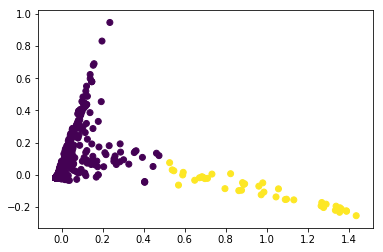

0.9437813923519338
44


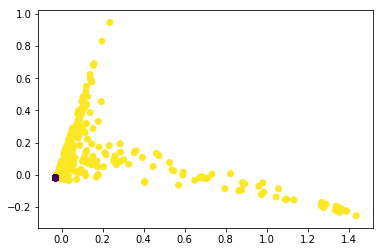

0.8101334929059139
340


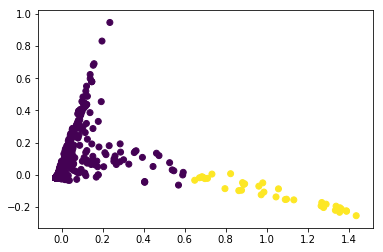

0.9450503955052012
38


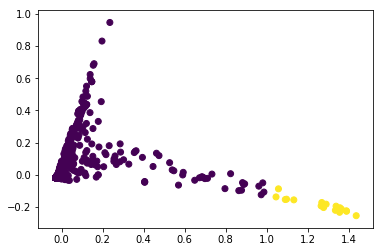

0.9430799908151131
19


In [22]:
# K-mean application and plotting
pca = PCA(n_components=2).fit_transform(input_data)
pred = KMeans(n_clusters=2, init='k-means++', n_init=10)
pred_kmeans = pred.fit_predict(pca)
plt.scatter(pca[:,0], pca[:,1], c=pred_kmeans)
plt.show()
compute_Sil_socre(pca, pred_kmeans)
computePassen(pred_kmeans)

# Get the result from Gussian Mixture
pred_Gussian = GaussianMixture(n_components = 2).fit_predict(input_data)
plt.scatter(pca[:,0], pca[:,1], c=pred_Gussian)
plt.show()
compute_Sil_socre(pca, pred_Gussian)
computePassen(pred_Gussian)

# AgglomerativeClustering
pred_AC = AgglomerativeClustering(n_clusters=2).fit_predict(pca)
plt.scatter(pca[:,0], pca[:,1], c=pred_AC)
plt.show()
compute_Sil_socre(pca, pred_AC)
computePassen(pred_AC)

# SpectralClustering
pred_SC = SpectralClustering(n_clusters = 2).fit_predict(pca)
plt.scatter(pca[:,0], pca[:,1], c=pred_SC)
plt.show()
compute_Sil_socre(pca, pred_SC)
computePassen(pred_SC)

In [25]:
# Write a method which can detect how many MACs
# are detected at each time stamp
def get_labeled_data(pred_label):
    temp = SFrame({'passenger': pred_label})
    data_regres = data.add_columns(temp)
    passen_data = data_regres.remove_columns(['end_latitude','end_longitude','start_latitude',
                                    'start_longitude', 'mac', 'count', 'distance', 'duration', 'speed'])
    input_csv = 'trip_detail.csv'
    date_list = []
    time_list = []
    passen_list = []
    with open(input_csv) as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        count = 0
        for row in reader:
            if count != 0:
                date = format_transform(row[0].split(',')[5])
                date_list.append(date)
                temp = row[1].split(',')
                time_list.append(temp[0])
                passen_list.append(int(temp[1]))
            count+=1    
    passen_frame = SFrame({'date': date_list, 'time': time_list, 'passenger': passen_list})
    # Loop A: Going through the passen_frame and grap the value of date and time
    # Loop B: Going through the passen_data, first check if it is a passenger,
    # then see if the date matches, check if 
    # the time is within the interval of start_time and end_time. If both yes, then
    # increment mac_count
    count_list = []
    lon_list = []
    lat_list = []
    stop_list = ['0']
    id_list = []
    date_list = ['0', '2018-03-06', '2018-03-01', '2018-02-26']
    date_id = []
    for i in passen_frame:
        date = i['date']
        time = i['time']
        mac_count = 0
        for j in passen_data:
            if j['passenger'] == 1 and j['date'] == date:
                if time_difference(j['start_time'], time) > 0 and time_difference(time, j['end_time']) > 0:
                    mac_count += 1
        count_list.append(mac_count)
        mac_count = 0
    return passen_frame.add_columns(SFrame({'count': count_list})), passen_list, count_list

In [49]:
passen_frame_Gussian, passen_Gaussian, count_Gassian = get_labeled_data(pred_Gussian)
passen_frame_Kmeans, passen_Kmeans, count_Kmeans = get_labeled_data(pred_kmeans)
passen_frame_AC, passen_AC, count_AC = get_labeled_data(pred_AC)
passen_frame_SC, passen_SC, count_SC = get_labeled_data(pred_SC)
euc_Gaussian,_ = compute_data_difference(passen_Gaussian, count_Gassian)
euc_kmeans,_ = compute_data_difference(passen_Kmeans, count_Kmeans)
euc_AC,_ = compute_data_difference(passen_AC, count_AC)
euc_SC,_ = compute_data_difference(passen_SC, count_SC)
print("Kmeans performance:", euc_kmeans)
print("Guassian performance:", euc_Gaussian)
print("Agglomerative Clustering performance:", euc_AC)
print("Spectral Clustering performance:", euc_SC)

Kmeans performance: 107.41042779916668
Guassian performance: 83.26463835266445
Agglomerative Clustering performance: 113.91663618629195
Spectral Clustering performance: 144.10065926289164


In [52]:
passen_frame_Gussian['conv_time'] = passen_frame_Gussian['time'].apply(lambda time: time_convert(time))
passen_frame_Gussian['label'] = passen_frame_Gussian['passenger'].apply(lambda passenger: int(passenger))

In [110]:
_, scalor_gaussian = compute_data_difference(passen_Gaussian, count_Gassian)
_, scalor_kmeans = compute_data_difference(passen_Kmeans, count_Kmeans)
# Multiply the mac counts by the number of scalor
count_list_Gussian = multiply(count_Gassian, scalor_gaussian)
count_list_Kmeans = multiply(count_Kmeans, scalor_kmeans)
passen_frame_Gussian = passen_frame_Gussian.add_columns(SFrame({'cps': count_list_Gussian}))
# Compute the error
evaluate(SArray(passen_Gaussian), SArray(count_list_Gussian))
evaluate(SArray(passen_Kmeans), SArray(count_list_Kmeans))

Mean Abosulute Percentage Error:  0.5989304812834223
Mean Square Error:  41.16883116883117
Mean Abosulute Percentage Error:  0.2551566080977845
Mean Square Error:  154.4935064935065


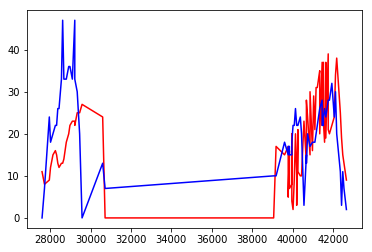

In [217]:
passen_frame_Gussian = passen_frame_Gussian.sort(['conv_time'])
plt.plot(passen_frame_Gussian['conv_time'], passen_frame_Gussian['label'], 'r-',
         passen_frame_Gussian['conv_time'], passen_frame_Gussian['cps'], 'b-')
plt.show()

In [186]:
evaluate(test_data['label'], result)

Mean Abosulute Percentage Error:  0.048715667337433904
Mean Square Error:  17.99410356977209


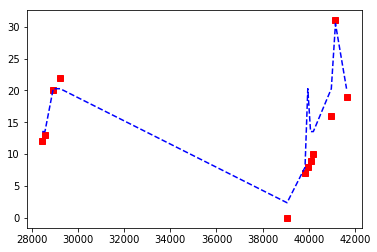

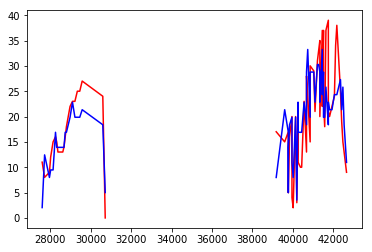

In [216]:
plt.figure(1)
plt.plot(test_data['conv_time'], test_data['label'], 'rs',
         test_data['conv_time'], result, 'b--')
plt.figure(2)
plt.plot(train_data['conv_time'][0:20], train_data['label'][0:20], 'r-',
         train_data['conv_time'][0:20], trained_model.predict(train_data)[0:20], 'b-')
plt.plot(train_data['conv_time'][20:65], train_data['label'][20:65], 'r-',
         train_data['conv_time'][20:65], trained_model.predict(train_data)[20:65], 'b-')
plt.show()